analyze NCI cervical cnv results

In [2]:
# import csv
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.stats import ttest_ind
# import scipy.stats as stats
# import scipy.stats as ss
# from matplotlib import style
# import matplotlib.gridspec as gridspec
# import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)


# from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
# from sklearn.linear_model import LogisticRegression
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler



# produce list of amplied and deleted regions with oncogenes

In [3]:
f1 = '/home/szong/projects/resource/oncogenes.and.tumor.suppressor.genes.txt'
df_tg = pd.read_csv(f1, header=None)
df_tg.head()

tgs = df_tg[0].tolist()

In [4]:
def summarize_genes(inf, tgs):
#     inf = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj/del_genes.conf_99.txt'
    df = pd.read_csv(inf, sep='\t', header=None)
    df.head(5)

    df.loc['genes',:] = df.apply(lambda x:  ','.join(set(x[~x.isnull()][4:])))
    df.loc['tg_genes',:] = df.apply(lambda x:  ','.join(m for m in set(x[~x.isnull()][4:]) if m in tgs))

    df.loc['num_genes',:] = df.count()-6

    df.shape

    df1 = df.loc[[0,1,2,3,'num_genes', 'tg_genes'],:].T
    df1['cancer_genes'] = df1.apply(lambda x: '({0}){1}'.format(x[4], x[5]), axis=1)

    df1.head()

#     of = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj/deletion_genes.txt'
    of = '{}.summary'.format(inf)
    df1.drop(['num_genes', 'tg_genes'], axis=1).to_csv(of, index=False, sep='\t')

In [5]:
!pwd

/projects/trans_scratch/validations/workspace/szong/Cervical/notebook


In [6]:
files = ['/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_pos/del_genes.conf_99.txt', '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_pos/amp_genes.conf_99.txt'] 
# files = ['/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/del_genes.conf_99.txt', '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/amp_genes.conf_99.txt']
for inf in files:
    summarize_genes(inf, tgs)
# to sort output
# cat deletion_genes.txt |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> deletion_genes_sorted.txt

In [8]:
files = ['/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg/del_genes.conf_99.txt', '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg/amp_genes.conf_99.txt'] 
# files = ['/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/del_genes.conf_99.txt', '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/amp_genes.conf_99.txt']
for inf in files:
    summarize_genes(inf, tgs)

In [7]:
%%bash
cd /home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_pos
cat del_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> del_genes.conf_99.txt.summary.sorted
cat amp_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> amp_genes.conf_99.txt.summary.sorted

In [53]:
def get_qvalue(f):
    df = pd.read_csv(f, sep='\t')
    df['gene'] = df['oncogenes'].apply(lambda x: x.split(')')[1])

    df = df[['q value', 'gene']]
    df = df[df.gene != '']

    s = df["gene"].str.split(',', expand=True).stack()
    i = s.index.get_level_values(0)
    df2 = df.loc[i].copy()
    df2["gene"] = s.values
    return df2

In [155]:
# for amps
pos_amp_file = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_pos/amp_genes.conf_99.txt.summary.sorted'
pos_amps = get_qvalue(pos_amp_file)
pos_amps.head(2)

neg_amp_file = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg/amp_genes.conf_99.txt.summary.sorted'
neg_amps = get_qvalue(neg_amp_file)
neg_amps.head(2)

ndf = pd.merge(pos_amps, neg_amps, left_on='gene', right_on='gene', how='outer').fillna(1)
ndf.columns = ['hiv+q', 'gene', 'hiv-q']
ndf.head(2)

,hiv+q,gene,hiv-q
0,0.003377,NFE2L2,1.0
1,0.003377,HOXD11,1.0


In [148]:
# for dels
pos_del_file = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_pos/del_genes.conf_99.txt.summary.sorted'
pos_dels = get_qvalue(pos_del_file)
pos_dels.head(2)

neg_del_file = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg/del_genes.conf_99.txt.summary.sorted'
neg_dels = get_qvalue(neg_del_file)
neg_dels.head(2)

ndf = pd.merge(pos_dels, neg_dels, left_on='gene', right_on='gene', how='outer')#.fillna(1)
ndf.columns = ['hiv+q', 'gene', 'hiv-q']
ndf.head(2)

,hiv+q,gene,hiv-q
0,0.055942,MDS2,NaN
1,0.055942,PARK7,NaN


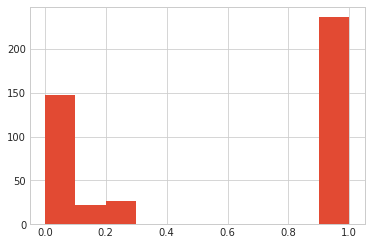

In [140]:
ndf['hiv+q'].hist()

In [147]:
# ndf

In [156]:
ndf = ndf.sort_values('hiv-q')

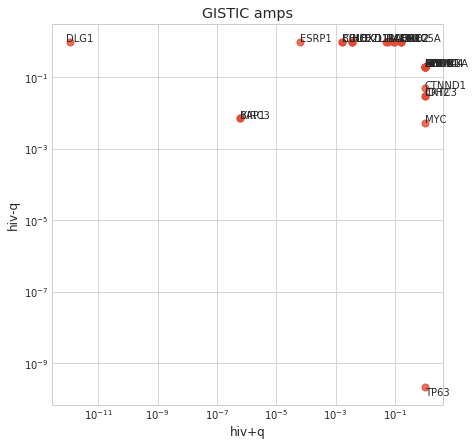

In [158]:
# Set theme
sns.set_style('whitegrid')


# Scatterplot arguments
# grid = sns.lmplot(x='hiv+q', y='hiv-q', data=ndf.fillna(.1),
#            fit_reg=False) # No regression line
#            #hue='Stage')   # Color by evolution stage
# # Tweak using Matplotlib
# # plt.ylim(0, .2)
# # plt.xlim(0, .2)
# grid.set(xscale="log", yscale="log")

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.regplot(x='hiv+q', y='hiv-q', data=ndf.fillna(1), ax=ax, fit_reg=False, x_jitter=1e-12, y_jitter=1e-10, scatter_kws={"s": 50})
ax.set_title('GISTIC amps')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    k = 0
    j = 0 
    for i, point in a.iterrows():
        _ = ax.text(point['x']+j, point['y']+k, str(point['val']))
#         k+=1e-3
#         j+=1e-8
    return a

_ = label_point(ndf['hiv+q'], ndf['hiv-q'], ndf['gene'], plt.gca())  
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/amp_gene_qvalue_comparison_hiv_pos_vs_neg.png'
plt.savefig(of, bbox_inches='tight', dpi=200)

In [102]:
ndf.head(2)

,hiv+q,gene,hiv-q
0,0.003377,NFE2L2,NaN
1,0.003377,HOXD11,NaN


In [153]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/amp_gene_qvalue_comparison_hiv_pos_vs_neg.txt'
ndf.to_csv(of, sep='\t', index=False)

In [9]:
%%bash
cd /home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg
cat del_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> del_genes.conf_99.txt.summary.sorted
cat amp_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> amp_genes.conf_99.txt.summary.sorted

# look at correlation between copy number and expression

In [49]:
df2

,q value,gene,new_gene
7,3.377000e-03,"NFE2L2,HOXD11,HOXD13",NFE2L2
7,3.377000e-03,"NFE2L2,HOXD11,HOXD13",HOXD11
7,3.377000e-03,"NFE2L2,HOXD11,HOXD13",HOXD13
9,8.332900e-13,DLG1,DLG1
16,5.524600e-02,RAC1,RAC1
20,6.399600e-05,ESRP1,ESRP1
22,8.899700e-02,UHRF2,UHRF2
26,1.518200e-01,"LMO2,EHF",LMO2
26,1.518200e-01,"LMO2,EHF",EHF
28,5.902500e-07,"YAP1,BIRC3",YAP1


In [ ]:
f = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/all_thresholded.by_genes.txt'
df = pd.read_csv(f, sep='\t')
df.head(2)

In [ ]:
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/expression/NCI_ensembl69_stranded_RPKM_matrix.txt'
df1 = pd.read_csv(f1, sep='\t')
df1.head(2)

In [ ]:
genes = ['ECT2', 'YAP1', 'DLG1',  'DNAH5',  'SP100', 'STK11']

In [ ]:
def categorize_cnv(i):
#     for i in s:
    if i < 0:
        cat = 'cnv_loss'
    elif i > 0:
        cat = 'cnv_gain'
    else: cat = 'cnv_neutral'
#         ns.append(cat)
    return cat

In [ ]:
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w', figsize=(12,12))
    axes = (fig.subplots(int(len(genes)/3), 3)).ravel()
#     print(axes[1])
    for i, gene in enumerate(genes):
        dfgene = df[df['Gene Symbol'] == gene]
        df1gene = df1[df1.genes.str.contains('_{}$'.format(gene))]
        dff = pd.concat([dfgene, df1gene]).drop(['Cytoband', 'Gene Symbol', 'Locus ID', 'genes'], axis=1).T
        dff.columns = ['cnv', 'rpkm']
#         dff['groups'] = ['cnv_loss' if i< 0 'cnv_gain' elif i>0 else 'cnv_neutral' for i in dff.cnv ]
        dff['groups'] = dff.cnv.apply(categorize_cnv)
#         print(dff['groups'].unique())
        # boxplot overlaps individual data point

        ax = axes[i]
        _ = sns.boxplot('groups', 'rpkm', data=dff, ax=ax, order=['cnv_loss', 'cnv_neutral', 'cnv_gain'])
        _ = sns.swarmplot('groups', 'rpkm', data=dff, ax=ax, order=['cnv_loss', 'cnv_neutral', 'cnv_gain'])
        _ = ax.set_title(gene)
        _ = ax.set_xlabel('')
        grps = {}
        # overlay actuall data point
        categories = ['cnv_loss','cnv_neutral', 'cnv_gain']
        group_col = 'groups'
        value_col = 'rpkm'
        for i, cat in enumerate(categories):
#             print(i, cat)
            grps[i] = dff.query('{0} == "{1}"'.format(group_col, cat))[value_col]

        if len(categories) == 2:
            # statistical test for 1st grp
#             sts, p = ss.mannwhitneyu(grps[0], grps[1], use_continuity=True, alternative=None)
            sts, p1 = ttest_ind(grps[0], grps[1])
#             print(p)
            p = round(p, 8)
            _ = ax.text(0.4 , 0.90,'p={}'.format(p), ha='center', va='center', transform=ax.transAxes, size=14)
        elif len(categories) == 3:
            # statistical test for 1st grp
#             sts, p1 = ss.mannwhitneyu(grps[0], grps[1], use_continuity=True, alternative=None)
            sts, p1 = ttest_ind(grps[0], grps[1])
#             print(p1)
            p1 = round(p1, 5)
            _ = ax.text(0.2 , 0.90,'p={}'.format(p1), ha='center', va='center', transform=ax.transAxes, size=14)
#             sts, p2 = ss.mannwhitneyu(grps[2], grps[1], use_continuity=True, alternative=None)
            sts, p2 = ttest_ind(grps[2], grps[1])
#             print(p2)
            p2 = round(p2, 5)
            _ = ax.text(0.7 , 0.90,'p={}'.format(p2), ha='center', va='center', transform=ax.transAxes, size=14)
    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cnv_expression.png'
    plt.savefig(of, dpi=200)